In [1]:
%cd ..
%rm -r lightning_logs/
%pwd

/home/quasar/GitHub/TradeForecast
rm: cannot remove 'lightning_logs/': No such file or directory


/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/quasar/GitHub/TradeForecast'

In [2]:
from tradeforecast.augmentation import RNNDataset
from tradeforecast.viz import plot_rnn_forecasts
from tradeforecast.forecast.base import LitBase
from torch.utils.data import DataLoader
from lightning import Trainer
from torch import Tensor
from torch import optim
import torch.nn.functional as F

def predict(model: LitBase, data_loader: DataLoader, dataset: RNNDataset):
    y: Tensor; y_pred: Tensor
    y, y_pred = model.predict(data_loader)
    y = dataset.inverse_transform(y.numpy())
    y_pred = dataset.inverse_transform(y_pred.numpy())
    plot_rnn_forecasts(y, y_pred)
    return

In [ ]:
from tradeforecast.augmentation import DataEntryPoint, Indicators, FeatureEngg

data_entry = DataEntryPoint(csv_fpath='AAPL_1d_max_(2010-01-01-2024-12-06).csv')

indicators = Indicators(data_entry)
indicators.add_moving_average().add_moving_average(n=30).add_macd_sl().add_rsi().add_atr()

features = FeatureEngg(data_entry)
features.add_quarters().add_weeks()

lf = data_entry.data.drop_nulls().drop('High','Low')
lf.head().collect()

Datetime,Close,Open,Volume,SMA_close_16,MACD_close_12-26,MACD-SL_close_9,RSI_close_14,ATR_close_14,Quarter_sin,Quarter_cos,Week_sin,Week_cos
"datetime[μs, EST]",f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-02-21 19:00:00 EST,7.157857,7.226429,390563600,7.064375,-0.020182,-0.043646,50.213892,0.152137,1.0,0.0,0.737833,0.674983
2010-02-22 19:00:00 EST,7.037857,7.142857,575094800,7.075536,-0.027162,-0.039953,40.503417,0.158657,1.0,0.0,0.812487,0.582979
2010-02-23 19:00:00 EST,7.166429,7.079643,460566400,7.088772,-0.02264,-0.036165,51.982977,0.158358,1.0,0.0,0.812487,0.582979
2010-02-24 19:00:00 EST,7.214286,7.049286,665126000,7.102478,-0.015228,-0.031669,55.657482,0.165709,1.0,0.0,0.812487,0.582979
2010-02-25 19:00:00 EST,7.307857,7.227857,507460800,7.114509,-0.002156,-0.025423,62.185845,0.158679,1.0,0.0,0.812487,0.582979


In [ ]:
from tradeforecast.augmentation import train_val_test_split

dataset_kwargs = {'lf': lf,
                 'non_temporal': [x for x in data_entry.non_temporal if x not in ['High', 'Low']],
                 'temporal': data_entry.temporal,
                 'target': 'Close',
                 'look_back_len': 60,
                 'forecast_len': 5}

rnn_dataset = RNNDataset(**dataset_kwargs)

train_dataset, test_dataset = train_val_test_split(rnn_dataset, test_size=0.1)

batch_size = 128
num_workers = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

## Train LSTM model

In [5]:
from tradeforecast.forecast import LSTM
from tradeforecast.forecast.utils import OverrideEpochStepCallback

lstm_kwargs = {'input_size': len(rnn_dataset.features),
              'hidden_size': 32,
              'n_LSTM': 2,
              'bidirectional': False,
              'fc_out_size':[],
              'output_size': rnn_dataset.forecast_len,
              'dropout': 0,
              'criterion': F.mse_loss,
              'lr': 0.1,
              'optimizer': optim.SGD}

lstm_model = LSTM(**lstm_kwargs)

lstm_trainer = Trainer(fast_dev_run=False, max_epochs=1000, log_every_n_steps=10, check_val_every_n_epoch=100)

lstm_trainer.fit(lstm_model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 14.3 K | train
1 | fc_linear | Sequential | 165    | train
-------------------------------------------------
14.5 K    Trainable params
0         Non-trainable params
14.5 K    Total params
0.058     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 26/26 [00:00<00:00, 77.82it/s, v_num=0, train/loss=0.00131, step=998.0, lr=0.00625]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 26/26 [00:00<00:00, 76.54it/s, v_num=0, train/loss=0.00131, step=998.0, lr=0.00625]


In [6]:
test_loss = lstm_trainer.test(lstm_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 239.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.1888875812292099
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


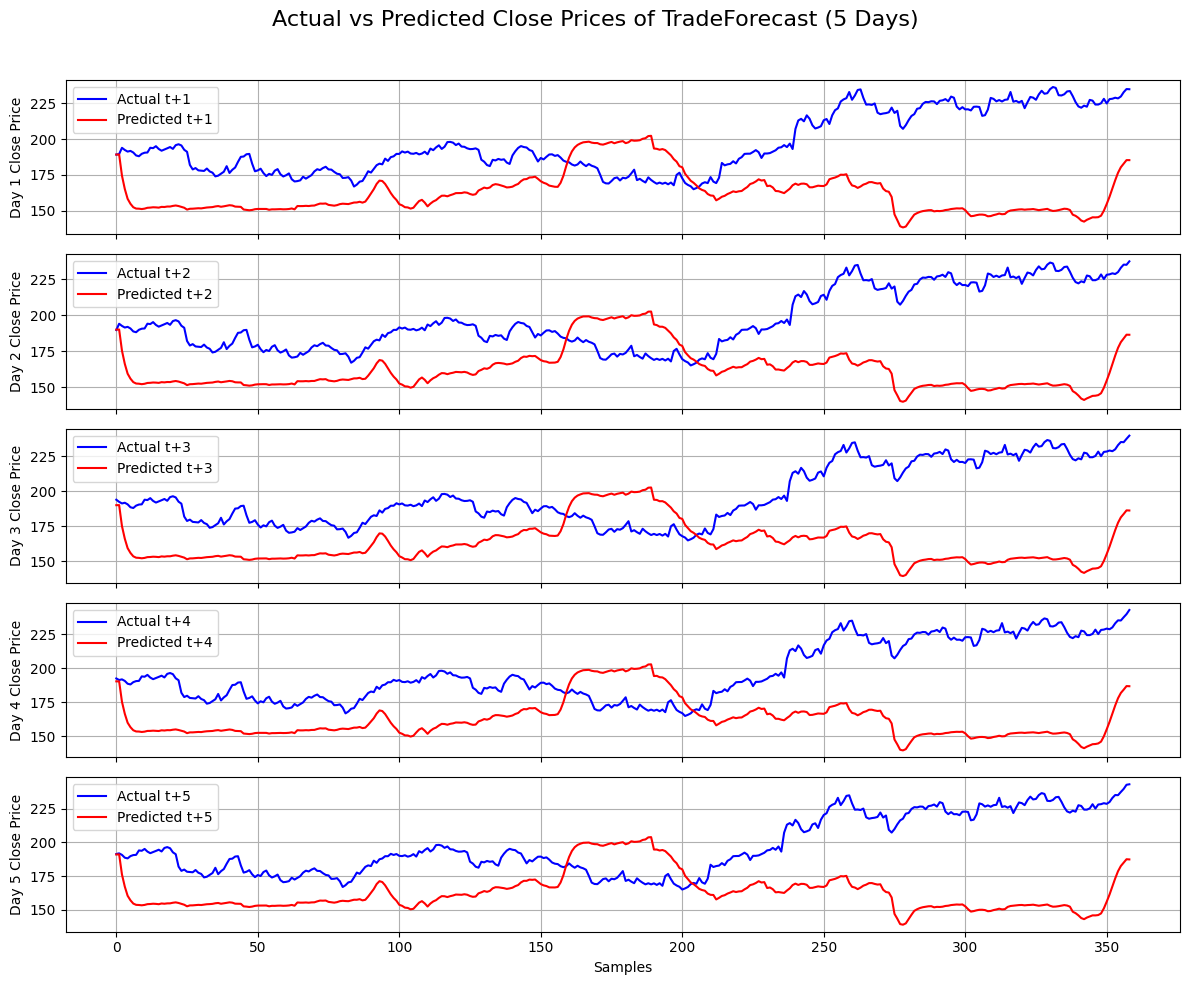

In [7]:
predict(lstm_model, test_loader, rnn_dataset)

In [8]:
model_fname = lstm_model.save_model_state(ticker_interval='AAPL_1d')
model_fname

'AAPL_1d_LSTM_14501_5.pth'

## Train TF model

In [9]:
from tradeforecast.forecast import TFModel

tf_kwargs = {'input_size': len(rnn_dataset.features),
            'conv_out_size': len(rnn_dataset.features)*2,
            'kernel_size': 5,
            'hidden_size': 64,
            'n_LSTM': 2,
            'bidirectional': False,
            'fc_out_size':[],
            'output_size': rnn_dataset.forecast_len,
            'dropout': 0.05,
            'criterion': F.mse_loss,
            'lr': 0.1,
            'optimizer': optim.SGD}

tf_model = TFModel(**tf_kwargs)

tf_trainer = Trainer(fast_dev_run=False, max_epochs=1000, log_every_n_steps=10, check_val_every_n_epoch=100)

tf_trainer.fit(tf_model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | conv1d    | Conv1d      | 1.5 K  | train
1 | bnorm     | BatchNorm1d | 48     | train
2 | avg_pool  | AvgPool1d   | 0      | train
3 | lstm      | LSTM        | 56.3 K | train
4 | fc_linear | Sequential  | 325    | train
--------------------------------------------------
58.2 K    Trainable params
0         Non-trainable params
58.2 K    Total params
0.233     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 26/26 [00:00<00:00, 67.40it/s, v_num=1, train/loss=0.00465, step=998.0, lr=1e-5]    

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 26/26 [00:00<00:00, 66.56it/s, v_num=1, train/loss=0.00465, step=998.0, lr=1e-5]


In [10]:
tf_trainer.test(tf_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 167.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/loss           0.5382640361785889
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.5382640361785889}]

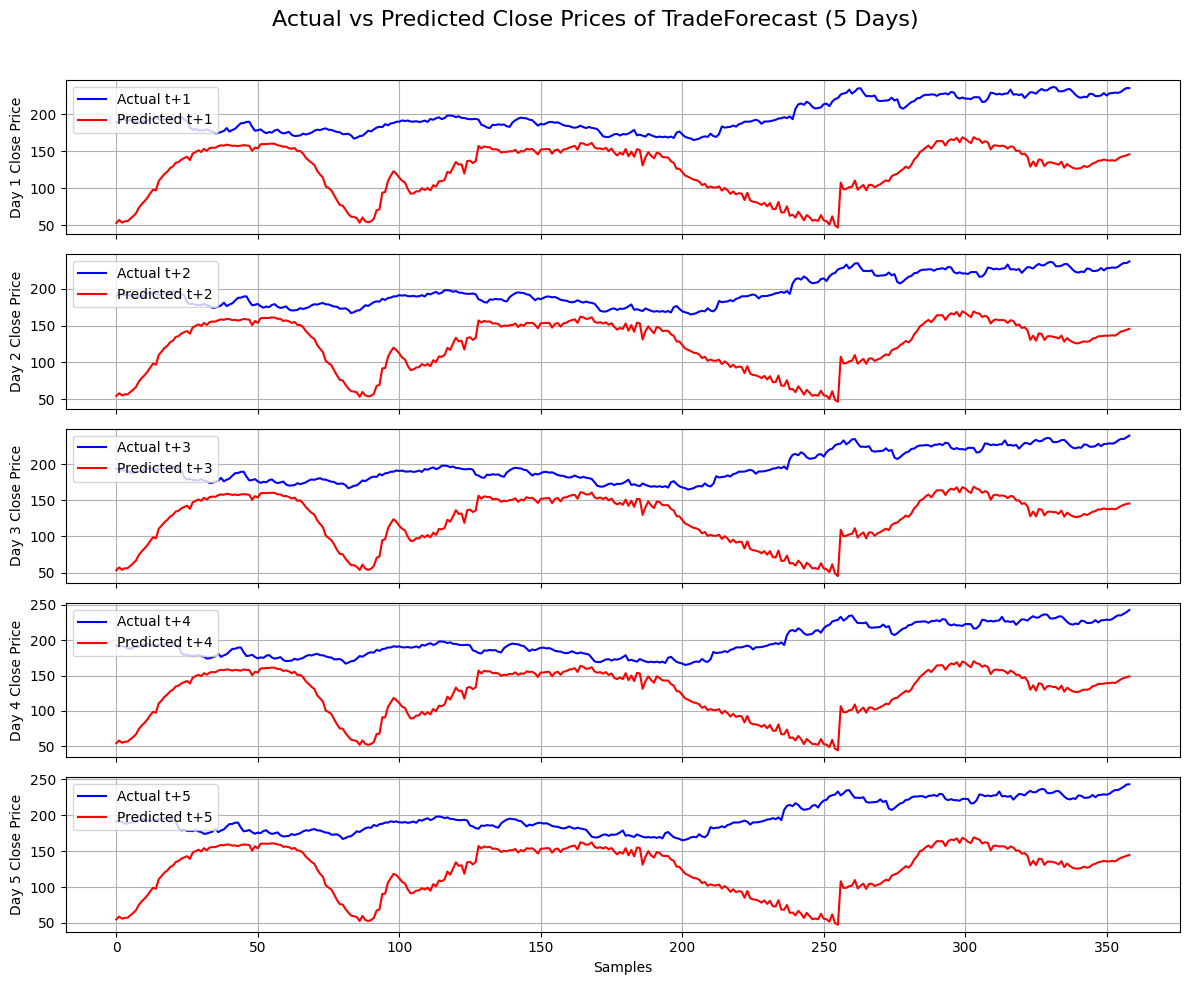

In [11]:
predict(tf_model, test_loader, rnn_dataset)

In [12]:
model_fname = tf_model.save_model_state(ticker_interval='AAPL_1d')
model_fname

'AAPL_1d_TFModel_58157_5.pth'

## Train TFTransformer Model

In [13]:
from tradeforecast.forecast import TFTransformer

tft_kwargs = {'input_size': len(rnn_dataset.features),
            'nhead': 4,
            'd_model': 64,
            'num_layers': 2,
            'output_size': rnn_dataset.forecast_len,
            'dropout': 0,
            'criterion': F.l1_loss,
            'lr': 0.1,
            'optimizer': optim.SGD}

tft_model = TFTransformer(**tft_kwargs)

tft_trainer = Trainer(fast_dev_run=False, max_epochs=1000, log_every_n_steps=10, check_val_every_n_epoch=100)

tft_trainer.fit(tft_model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | input_layer         | Linear             | 832    | train
1 | positional_encoding | PositionalEncoding | 0      | train
2 | encoder             | TransformerEncoder | 562 K  | train
3 | output_layer        | Linear             | 325    | train
-------------------------------------------------------------------
563 K     Trainable params
0         Non-trainable params
563 K     Total params
2.254     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval 

Epoch 54: 100%|██████████| 26/26 [00:00<00:00, 35.67it/s, v_num=2, train/loss=0.363, step=53.00, lr=0.000391]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
tft_trainer.test(tft_model, test_loader)

In [ ]:
predict(tft_model, test_loader, rnn_dataset)

In [ ]:
model_fname = tft_model.save_model_state(ticker_interval='AAPL_1d')
model_fname